#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

План работы:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders`.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Итоги-исследования" data-toc-modified-id="Итоги-исследования-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Итоги исследования</a></span></li></ul></div>

## Подготовка

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import uniform

In [2]:
# сохраним данные в переменную
df = pd.read_csv('taxi.csv',  index_col=[0], parse_dates=[0])

In [3]:
# Посмотрим на таблицу с данными
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [4]:
# Выведем общую информацию о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
# посмотрим на долю пропусков
pd.DataFrame(round(df.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
num_orders,0.000000


In [6]:
# Проверим временной ряд на монотонность
df.index.is_monotonic

True

Порядок соблюден

In [7]:
# Выполним ресемплирование по одному часу
df = df.resample('1H').sum()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


**Вывод**

В изначальном датасете 26496 объектов. Целевой признак находится в столбце num_orders.

Столбец с временным рядом был преобразован в тип datetime64 и установлен в качестве индекса таблицы.
Также было выполнено ресемплирование данных по одному часу. Данные представлены за период с 2018-03-01 00:00:00 по 2018-08-31 23:00:00.

В обработанной таблице получилось 4416 объектов. Данных достаточно для проведения дальнейшего анализа и построения модели предсказания.

## Анализ

In [9]:
# Скопируем данные в другую таблицу
df1 = df[['num_orders']]

Построим график количества заказов за каждый час для всего временного ряда.

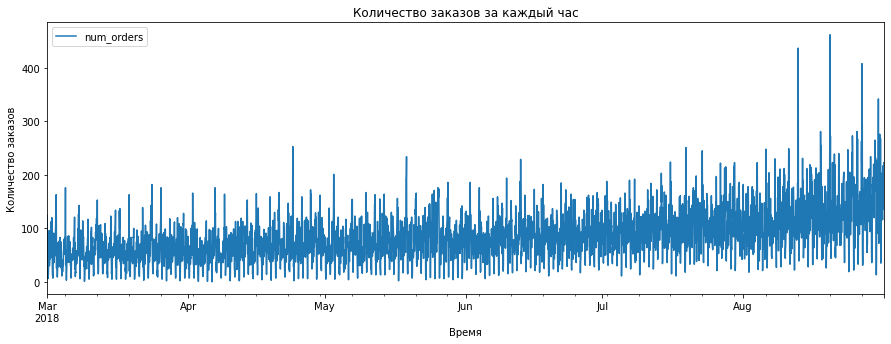

In [10]:
df1.plot(figsize=(15,5))
plt.title('Количество заказов за каждый час')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.show()

По данному графику трудно делать какие-либо выводы, так как на нем отображено слишком большое количество данных. Возьмем промежуток в один месяц и исследуем его.

Построим график за август.

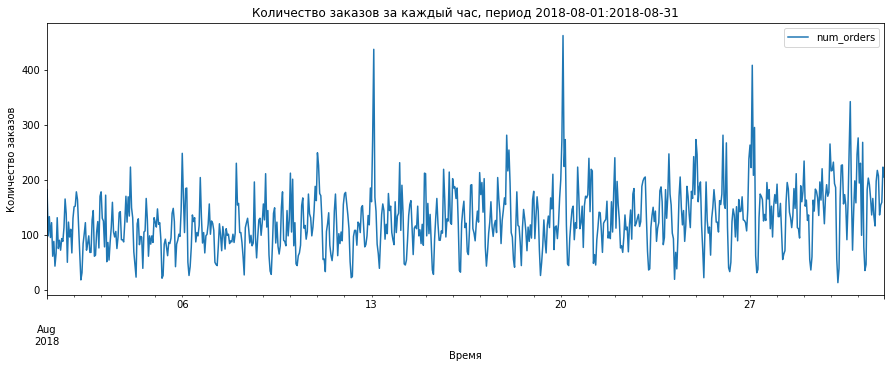

In [11]:
df1['2018-08-01':].plot(figsize=(15,5))
plt.title('Количество заказов за каждый час, период 2018-08-01:2018-08-31')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.show()

In [12]:
# Вычислим скользящее среднее с окном 24
df1['rolling_mean'] = df1.rolling(24).mean() 

Отобразим скользящее среднее на графике.

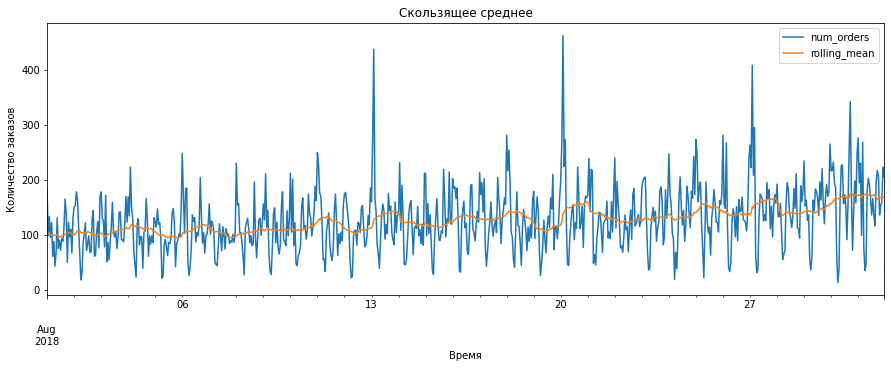

In [13]:
df1['2018-08-01':].plot(figsize=(15,5))
plt.title('Скользящее среднее')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.show()

Прослеживается возрастающий тренд

In [14]:
# Вычислим скользящее стандартное отклонение
df1['rolling_std'] = df1['num_orders'].rolling(24).std()

Построим график скользящего стандартного отклонения.

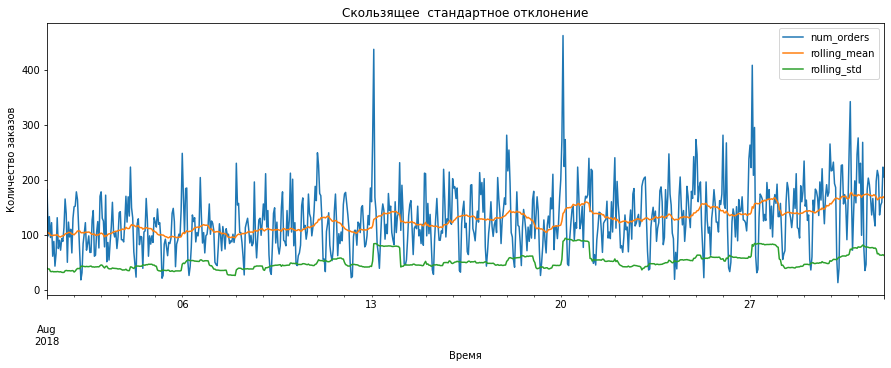

In [15]:
df1['2018-08-01':].plot(figsize=(15,5))
plt.title('Скользящее  стандартное отклонение')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.show()

Построим график тренда, сезонной компоненты и остатка временного ряда.

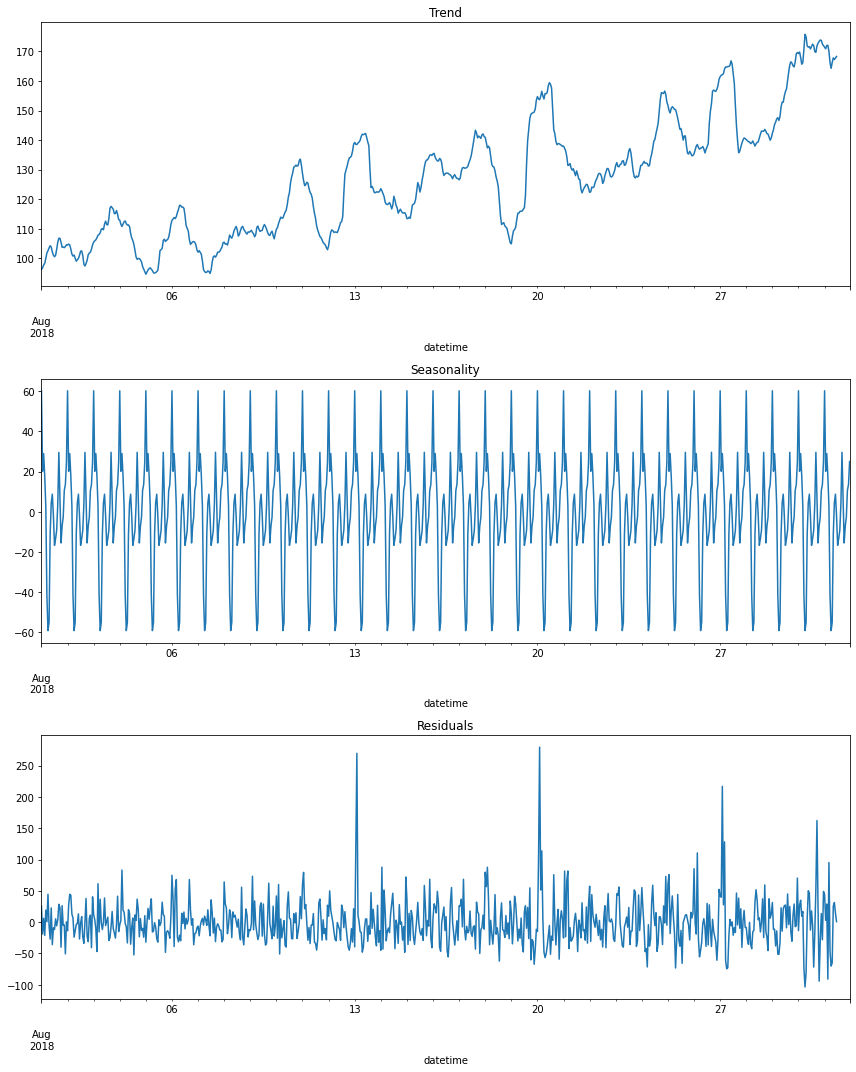

In [17]:
decomposed = seasonal_decompose(df1['num_orders']) 

plt.figure(figsize=(12, 15))
plt.subplot(311)
decomposed.trend['2018-08-01':].plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal['2018-08-01':].plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid['2018-08-01':].plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

График сезонной компоненты ряда за 3 дня.

Text(0.5, 1.0, 'Seasonality')

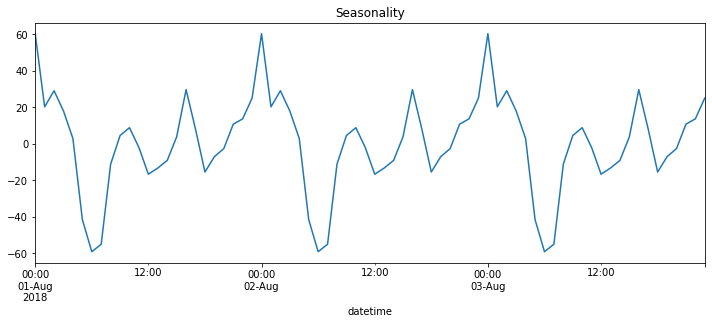

In [18]:
decomposed = seasonal_decompose(df1['num_orders']) 

plt.figure(figsize=(12, 15))
plt.subplot(312)
decomposed.seasonal['2018-08-01':'2018-08-03'].plot(ax=plt.gca())
plt.title('Seasonality')

In [19]:
df1 = df1['2018-08-01':]

In [20]:
# Вычислим разности временного ряда
df1 = df1 - df1.shift()

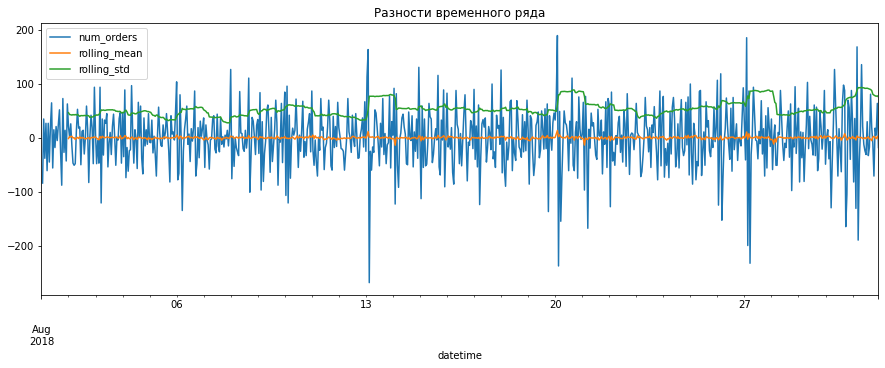

In [21]:
# График временного ряда после преобразования
df1['rolling_mean'] = df1['num_orders'].rolling(24).mean()
df1['rolling_std'] = df1['num_orders'].rolling(24).std()
df1.plot(figsize=(15,5))
plt.title('Разности временного ряда')
plt.show()

**Вывод**

Были исследованы различные графики временного ряда. Исследование показало:

- Количество заказов плавно растет с каждым месяцем, т.е. наблюдается тренд. Следовательно можно сделать вывод о том, что ряд не стационарный.
- Сезонность на графике с периодом в 1 день показала, что пик количества заказов приходится на 12 часов ночи и далее медленно убывает. Меньше всего заказов в 6 утра и далее оно начинает расти, так как люди выезжают на работу.
- После дифференцирования (нахождения разностей) временного ряда, ряд стал более стационарным - пропал тренд. Значит данные можно прогнозировать.

## Обучение

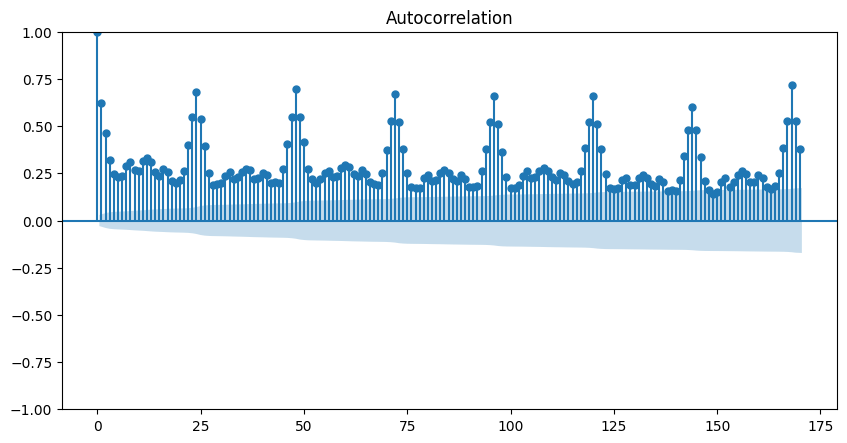

In [22]:
# Построим график автокорреляции временного ряда на 170 лагов
fig,ax = plt.subplots(figsize=(10,5), dpi=100)
plot_acf(df['num_orders'], lags=170, alpha=0.05, ax=ax)

plt.show()

In [23]:
# Функция создания признаков
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Для расчета количества лагов для последующего обучения моделей умножим 24 часа на 7 дней. Получается 168 лагов посчитаем и добавим в нашу таблицу признаков. Это подтверждает график автокорреляции, так как на нем автокорреляционные коэфициенты примерно на этом значении начинают пересекать границу зоны значимости.

In [24]:
# создаем признаки
make_features(df, 168, 24)

In [25]:
# поделим нашу таблицу на обучающую и тестовую выборки, не перемешивая ее
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

In [26]:
# проверим размеры получившихся таблиц
train.shape, test.shape

((3806, 174), (442, 174))

In [27]:
# Создадим таблицы признаков и  таргетов
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

**Обучим и подберем гиперпараметры для модели линейной регрессии**

In [28]:
tscv = TimeSeriesSplit(n_splits=5)

model_lin = LinearRegression()

param_lin = {
    'fit_intercept': [True,False],
    'normalize': [True,False]
}

scorer = make_scorer(mean_squared_error, squared=False)

random_search = RandomizedSearchCV(model_lin, param_lin, n_iter=4, scoring=scorer, cv=tscv, random_state=42)
random_search.fit(features_train, target_train)

best_params = random_search.best_params_
best_model_lr = random_search.best_estimator_
best_score_lr = random_search.best_score_

print("Лучшие параметры: ", best_params)
print("Метрика лучшей модели: ", best_score_lr)

Лучшие параметры:  {'normalize': True, 'fit_intercept': True}
Метрика лучшей модели:  23.134753214941515


**Обучим модель лассо на разных гиперпараметрах**

In [29]:
lasso = Lasso()
tscv = TimeSeriesSplit(n_splits=5)

param_dist = {"alpha":uniform(0,1)}

scorer = make_scorer(mean_squared_error, squared=False)

random_search = RandomizedSearchCV(lasso, param_distributions=param_dist, n_iter=10, scoring=scorer, cv=tscv, random_state=42)
random_search.fit(features_train, target_train)

best_params_lasso = random_search.best_params_
best_model_lasso = random_search.best_estimator_
best_score_lasso = random_search.best_score_

print("Лучшие параметры: ", best_params_lasso)
print("Метрика лучшей модели: ", best_score_lasso)

Лучшие параметры:  {'alpha': 0.05808361216819946}
Метрика лучшей модели:  22.551972436437413


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 387249.3675089515, tolerance: 569.3793103783499
  model = cd_fast.enet_coordinate_descent(


**Обучим и подберем гиперпараметры для модели Catboost**

In [37]:
model = CatBoostRegressor(loss_function='RMSE', verbose=False)
tscv = TimeSeriesSplit(n_splits=5)

param_cat = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [1,3,5,7,9,11],
    'iterations': [10,50,100,200]
}
random_search = RandomizedSearchCV(model, param_cat, n_iter=10, scoring='neg_mean_squared_error', cv=tscv, 
                                   n_jobs=-1, verbose=False)
random_search.fit(features_train, target_train)

best_params_cb = random_search.best_params_
best_model_cb = random_search.best_estimator_
best_score_cb = random_search.best_score_

print("Лучшие параметры: ", best_params_cb)
print("Метрика лучшей модели: ", np.sqrt(-best_score_cb))

Лучшие параметры:  {'learning_rate': 0.1, 'iterations': 100, 'depth': 1}
Метрика лучшей модели:  23.30537618193909


**Вывод**

Лучшую метрику RMSE показала модель Лассо = 22.55197. Возьмем ее для тестирования.

## Тестирование

In [50]:
# Применим лучшую модель к тестовой выборке
pred = best_model_lasso.predict(features_test)
print("RMSE тестовой выборки:", (mean_squared_error(target_test, pred))**0.5)

RMSE тестовой выборки: 35.206131339698686


In [62]:
# Соберем в один датафрейм значения исходного и предсказанного рядов
pred = pd.DataFrame(data=pred)
df_fin = target_test.to_frame(name='target')
df_fin = df_fin.reset_index()
df_fin = pd.concat([df_fin,pred],sort=False, axis=1)
df_fin = df_fin.set_index('datetime')
df_fin.columns = ['target', 'predictions']

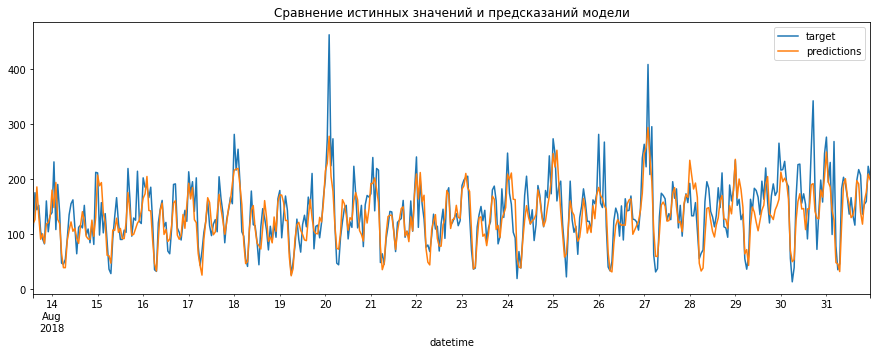

In [92]:
# Построим график таргетов и предсказаний модели Лассо
df_fin.plot(figsize=(15,5))
plt.title('Сравнение истинных значений и предсказаний модели')
plt.show()

## Итоги исследования

Был проведен исследовательский анализ временного ряда с количеством заказов такси. Данные были ресемплированы по одному часу.

Также были исследованы различные графики временного ряда. Исследование показало:

- Количество заказов плавно растет с каждым месяцем, т.е. наблюдается тренд. 
- Сезонность на графике с периодом в 1 день показала, что пик количества заказов приходится на 12 часов ночи и далее медленно убывает. Меньше всего заказов в 6 утра и далее оно начинает расти, так как люди выезжают на работу.
- После дифференцирования (нахождения разностей) временного ряда, ряд стал более стационарным - пропал тренд. 

Построены три модели для решения задачи регрессии (линейная регрессия, Лассо и Catboost). Их качество оценивалось метрикой RMSE. Лучшее качество по метрике RMSE показала модель Лассо = 22.55197. Она была взята для финального тестирования, где RMSE = 35.20613. Удалось добиться значения не больше 48.